##### Image dataset: https://www.kaggle.com/datasets/hlrhegemony/pokemon-image-dataset?resource=download
##### Metainfo csv: https://github.com/lgreski/pokemonData/blob/master/Pokemon.csv
##### You can speed up model inference on colab by changing Hardware accelerator in runtime type to any GPU option

# Project2 - Data Representations and Clustering

## Part 3 - Clustering using Both Image and Text

In [13]:
!pip install kagglehub

In [ ]:
import os
import kagglehub
import shutil

dataset_name = "hlrhegemony/pokemon-image-dataset"
dataset_dir = "./images"  # the dir name, don't change!!

# Create the directory if it doesn't exist
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# Check if the folder is empty
if not os.listdir(dataset_dir): 
    print("Dataset not found locally. Downloading...")
    # Download the dataset
    path = kagglehub.dataset_download(dataset_name)
    
    if path and os.path.isdir(path):  # Check if path is valid and directory exists
        print("Download complete. Path to dataset files:", path)
        
        # Move the dataset files to 'images' directory
        for item in os.listdir(path):
            s = os.path.join(path, item)
            d = os.path.join(dataset_dir, item)
            shutil.move(s, d)  # Move the file/folder into 'images'
        
        print(f"Dataset moved to {dataset_dir}")
    else:
        print("Error: Dataset download failed or path is empty.")
else:
    print("Dataset already exists. Skipping download.")

Dataset not found locally. Downloading...
Download complete. Path to dataset files: /Users/rickyang/.cache/kagglehub/datasets/hlrhegemony/pokemon-image-dataset/versions/2
Dataset moved to images/


### Helper code for setting up

In [ ]:
!pip install datasets transformers numpy pandas Pillow matplotlib
!pip install torch tqdm scipy
!pip install git+https://github.com/openai/CLIP.git
!pip install plotly umap-learn

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/pt/txr2ph2x1mg5gnx3y34z_1l00000gn/T/pip-req-build-o4p2p909
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/pt/txr2ph2x1mg5gnx3y34z_1l00000gn/T/pip-req-build-o4p2p909
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import clip
import torch
from tqdm import tqdm
from scipy.special import softmax
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random


/Users/rickyang/.pyenv/versions/3.10.12/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# load csv file and image paths to construct pokedex, use type_to_load=None to load all types, else use a list of types 1 to load
def construct_pokedex(csv_path='Pokemon.csv', image_dir='./images/', type_to_load=None):
    pokedex = pd.read_csv(csv_path)
    image_paths = []

    for pokemon_name in pokedex["Name"]:
        imgs = glob(f"{image_dir}/{pokemon_name}/0.jpg")
        if len(imgs) > 0:
            image_paths.append(imgs[0])
        else:
            image_paths.append(None)

    pokedex["image_path"] = image_paths
    pokedex = pokedex[pokedex["image_path"].notna()].reset_index(drop=True)

    # only keep pokemon with distinct id
    ids, id_counts = np.unique(pokedex["ID"], return_counts=True)
    ids, id_counts = np.array(ids), np.array(id_counts)
    keep_ids = ids[id_counts == 1]

    pokedex = pokedex[pokedex["ID"].isin(keep_ids)].reset_index(drop=True)
    pokedex["Type2"] = pokedex["Type2"].str.strip()
    if type_to_load is not None:
        pokedex = pokedex[pokedex["Type1"].isin(type_to_load)].reset_index(drop=True)
    return pokedex #dataframe include ID, name , Type1, Type2, image_path

# load clip model
def load_clip_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-L/14", device=device)
    return model, preprocess, device #preprocess: image preprocess function

# inference clip model on a list of image path
def clip_inference_image(model, preprocess, image_paths, device):
    image_embeddings = []
    with torch.no_grad():
        for img_path in tqdm(image_paths):
            img = Image.open(img_path)
            img_preprocessed = preprocess(img).unsqueeze(0).to(device)
            image_embedding = model.encode_image(img_preprocessed).detach().cpu().numpy()
            image_embeddings += [image_embedding]

    image_embeddings = np.concatenate(image_embeddings, axis=0)
    image_embeddings /= np.linalg.norm(image_embeddings, axis=-1, keepdims=True)
    return image_embeddings #(N, 768) numpy array, each line is image embedding.

# inference clip model on a list of texts
def clip_inference_text(model, preprocess, texts, device):
    with torch.no_grad():
        text_embeddings = model.encode_text(clip.tokenize(texts).to(device)).detach().cpu().numpy()
    text_embeddings /= np.linalg.norm(text_embeddings, axis=-1, keepdims=True)
    return text_embeddings #(M, 768) numpy array

# compute similarity of texts to each image
def compute_similarity_text_to_image(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=-1)
    return similarity #(N, M) numpy array.

# compute similarity of images to each text
def compute_similarity_image_to_text(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=0)
    return similarity

# Use TSNE to project CLIP embeddings to 2D space
def umap_projection(image_embeddings, n_neighbors=15, min_dist=0.1, metric='cosine'):
    distance_matrix = np.zeros((image_embeddings.shape[0], image_embeddings.shape[0]))
    for i in range(image_embeddings.shape[0]):
        for j in range(image_embeddings.shape[0]):
            if i == j:
                distance_matrix[i, j] = 1
            else:
                distance_matrix[i, j] = np.dot(image_embeddings[i], image_embeddings[j])
    distance_matrix = 1 - distance_matrix
    reducer = TSNE(n_components=2, metric="precomputed", init="random", random_state=42)
    visualization_data = reducer.fit_transform(distance_matrix)
    return visualization_data #(N, 2) numpy array,

### Question 26.

Todo:  Retrieve Pokémon Images Based on Text Queries

In [ ]:
# load the pokedex dataframe
pokedex = construct_pokedex()

# in case of the error that type is NaN error..
pokedex["Type2"] = pokedex["Type2"].fillna('None')

# load CLIP model
model, preprocess, device = load_clip_model()

# find the most suitable template
query_templates = [
    "type: Fire",
    "Fire type Pokémon",
    "Pokémon with fire abilities",
    "Fire Pokémon"
]

#query_templates_embeddings = clip_inference_text(model, preprocess, query_templates, device)
image_embeddings = clip_inference_image(model, preprocess, pokedex["image_path"].tolist(), device) # this takes long time

# compute similarity scores for each query
#all_similarities = []
#for query_embedding in query_templates_embeddings:
    #similarity = compute_similarity_text_to_image(image_embeddings, query_embedding)
    #test_similarity = compute_similarity_text_to_image(image_embeddings, query_templates_embeddings)
    #all_similarities.append(test_similarity)

# rank the performance
#for i, template in enumerate(query_templates):
    #print(f"Query: {template}, Avg Similarity: {all_similarities[i].mean():.4f}")

100%|██████████| 754/754 [02:20<00:00,  5.37it/s]


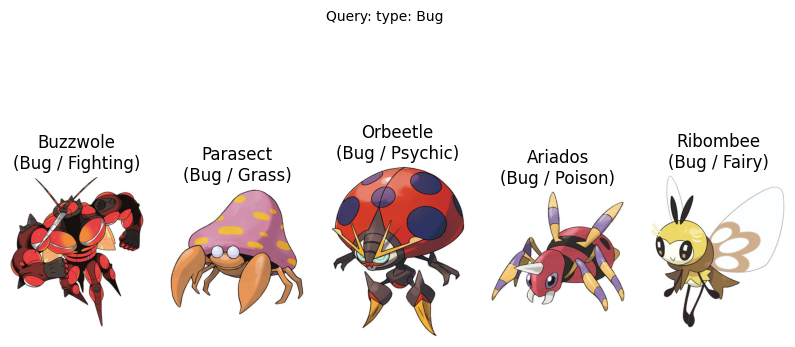

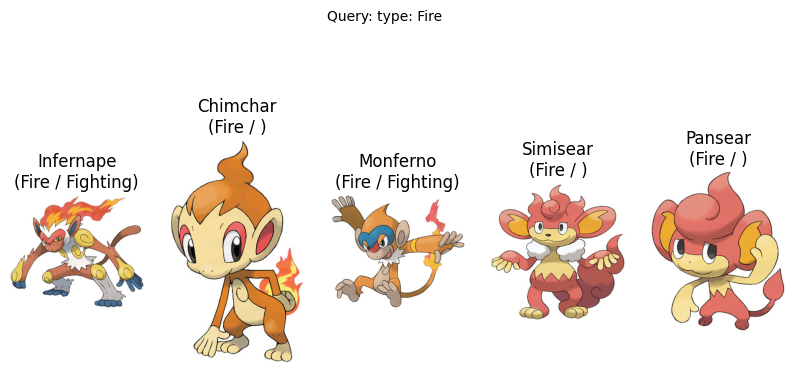

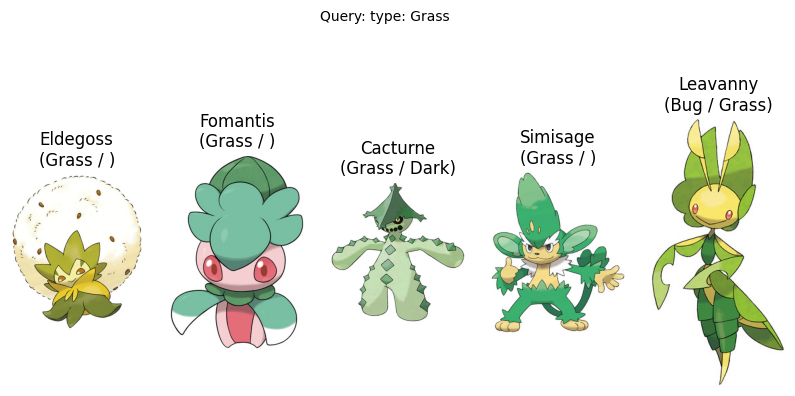

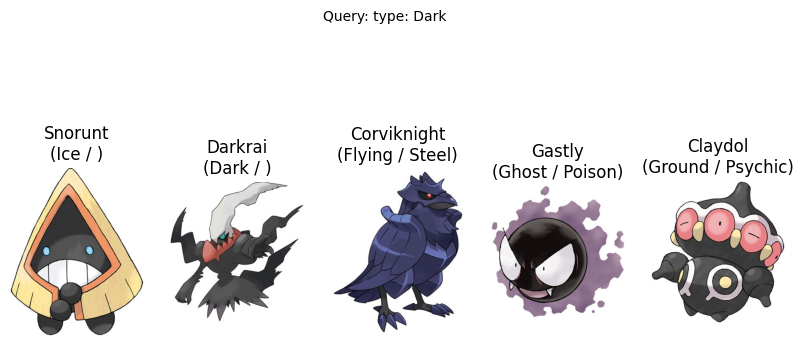

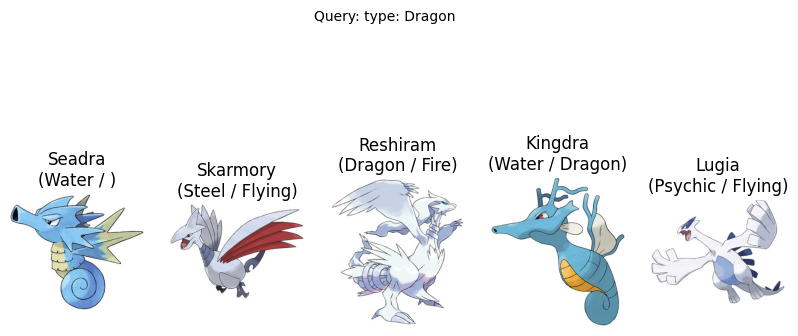

In [ ]:

queries = ["type: Bug", 
           "type: Fire", 
           "type: Grass",
           "type: Dark", 
           "type: Dragon"
           ]

#image_embeddings = clip_inference_image(model, preprocess, pokedex["image_path"], device)
text_embeddings = clip_inference_text(model, preprocess, queries, device)

# calculate the similarity between the textual and image label
similarity = compute_similarity_text_to_image(image_embeddings, text_embeddings)

top_matches = similarity.argsort(axis=0)[-5:][::-1]  # top 5 most relevant Pokemon

# visualize the top 5. 
def visualize_top_pokemon(query, top_matches, pokedex):
    fig, axes = plt.subplots(1, 5, figsize=(10, 5))
    fig.suptitle(f"Query: {query}", fontsize=10)

    for i, idx in enumerate(top_matches):
        img_path = pokedex.iloc[idx]["image_path"]
        name = pokedex.iloc[idx]["Name"]
        type1 = pokedex.iloc[idx]["Type1"]
        type2 = pokedex.iloc[idx]["Type2"]

        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"{name}\n({type1} / {type2})")

    plt.show()

for i, query in enumerate(queries):
    visualize_top_pokemon(query, top_matches[:, i], pokedex)

Ans:

The correctness for each:
- Fire: 5/5
- Bug: 5/5
- Grass: 5/5
- Dark: 1/5
- Dragon: 2/5

The effectiveness of Dark and Dragon type queries is notably lower compared to the first three. One possible explanation for this is the overlap of certain features with other Dragon types, which makes it harder for the model to confidently pick the correct type. For example, Dark types have visual similarities with Ghost types (dark color), and since CLIP models match the text and image based on similarity, it may confuse one type with another if their visual patterns are similar. For instance, Pokémon like “Seadra” and “Skarmory” in the image appear to be Dragon types but are misclassified as such, when they are actually Water and Steel/Flying types.

### Question 27: Predict Pokémon Type from Images

Todo:
1. Randomly Select 10 Pokémon images from the dataset.
2. Find the most relevant types, use perferred queries.
3.	Visualize results, Show Pokémon images with their real type and top-5 predicted types + confidence scores.

In [6]:
np.random.seed(219)
# sample 10 random Pokémon
sample_pokemon = pokedex.sample(10).reset_index(drop=True)
sample_image_paths = sample_pokemon["image_path"].tolist()
sample_pokemon_names = sample_pokemon["Name"].tolist()
# sample_indices = sample_pokemon.index.tolist()
# create text queries for Pokémon types
pokemon_types = pokedex["Type1"].unique()
text_queries = [f"type: {t}" for t in pokemon_types] # queries
# pokemon_types
top_k = 5  
def predict_types(img_paths):
    """Predict Pokémon types given image paths using CLIP model."""
    query_embeddings = clip_inference_text(model, preprocess, text_queries, device)
    image_embeddings = clip_inference_image(model, preprocess, img_paths, device)

    # compute Similarity of Query to Images
    query_to_img_similarity = compute_similarity_text_to_image(image_embeddings, query_embeddings)

    # get Top 5 predictions for each image
    poke_types = [
        [(text_queries[i], score[i]) for i in np.argsort(score)[-top_k:][::-1]]  # 获取前5个最相关的 type
        for score in query_to_img_similarity
    ]

    return poke_types

100%|██████████| 10/10 [00:02<00:00,  4.86it/s]


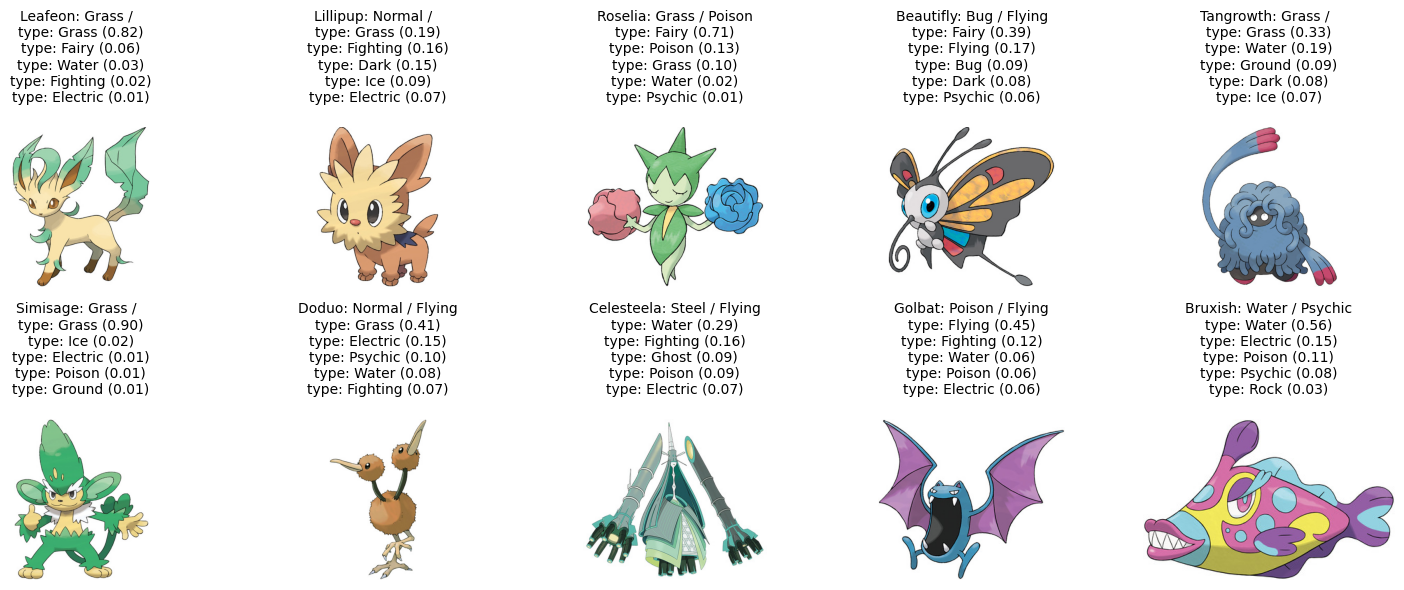

In [ ]:

# Predict types for all images
all_predicted_types = predict_types(sample_image_paths)

# plot Pokémon images and predicted types
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, (img_path, name, preds, type1, type2) in enumerate(zip(
    sample_image_paths, sample_pokemon_names, all_predicted_types, 
    sample_pokemon["Type1"], sample_pokemon["Type2"]
)):
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis("off")
    
    # if type2 is None, replace with empty string
    type2 = type2 if isinstance(type2, str) and type2.strip() != "" else " "

    title = f"{name}: {type1} / {type2}\n"
    
    for j in range(min(top_k, len(preds))): 
        predicted_type, prob = preds[j]
        title += f"{predicted_type} ({prob:.2f})\n"

    axes[i].set_title(title, fontsize=10)

plt.tight_layout()
plt.show()

### Question 28: Visualize Pokémon Clusters Using t-SNE

Todo
1. Use t-SNE to reduce dimensionality from CLIP embeddings (768D → 2D).
2. Create a scatter plot using plotly or matplotlib.
3. Color each point based on Pokémon’s primary type （type_1) using `color` argument.
4. Enable hover tooltips to show Pokémon names and types using `hover_name`.
5. Q: Analyze cluster distribution: Check if Pokémon of the same type are grouped together. If the clustering of Pokemon Types make sense?

In [ ]:

select_types = ['Bug', 'Fire', 'Grass']
pokedex_filtered = pokedex[pokedex["Type1"].isin(select_types)].reset_index(drop=True)

# compute CLIP embeddings only for the selected Pokémon
#image_embeddings_filtered = clip_inference_image(model, preprocess, pokedex_filtered["image_path"], device)
image_embeddings_filtered = image_embeddings[pokedex["Type1"].isin(select_types)]

# Perform TSNE dimensionality reduction, only for the select types. 
visualization_data = umap_projection(image_embeddings_filtered)
# global embedding, but the plot has a lot outliers, probably not for the question requirements
#visualization_data = umap_projection(image_embeddings)

# create a DataFrame for visualization
df_vis = pd.DataFrame(visualization_data, columns=["x", "y"])
df_vis["Type1"] = pokedex_filtered["Type1"]  
df_vis["name"] = pokedex_filtered["Name"]

# visualize Pokemon CLIP embeddings
fig = px.scatter(df_vis, x="x", y="y", color="Type1", hover_name="name", 
                 title="Pokémon CLIP Embeddings (TSNE Projection) - Grass, Fire, Bug")
fig.show()